<a href="https://colab.research.google.com/github/Yasminebenhamadi/NMA/blob/main/CN/W1D5_Tutorial4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bonus Tutorial: Diving Deeper into Decoding & Encoding

**Week 1, Day 5: Deep Learning**

**By Neuromatch Academy**

**Content creators**: Jorge A. Menendez, Carsen Stringer

**Content reviewers**: Roozbeh Farhoodi,  Madineh Sarvestani, Kshitij Dwivedi, Spiros Chavlis, Ella Batty, Michael Waskom

---
# Setup


In [ ]:
# Imports
import os
import numpy as np

import torch
from torch import nn
from torch import optim

import matplotlib as mpl
from matplotlib import pyplot as plt

In [ ]:
#@title Data retrieval and loading
import hashlib
import requests

fname = "W3D4_stringer_oribinned1.npz"
url = "https://osf.io/683xc/download"
expected_md5 = "436599dfd8ebe6019f066c38aed20580"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
#@title Figure Settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
#@title Plotting Functions

def plot_data_matrix(X, ax):
  """Visualize data matrix of neural responses using a heatmap

  Args:
    X (torch.Tensor or np.ndarray): matrix of neural responses to visualize
        with a heatmap
    ax (matplotlib axes): where to plot

  """

  cax = ax.imshow(X, cmap=mpl.cm.pink, vmin=np.percentile(X, 1), vmax=np.percentile(X, 99))
  cbar = plt.colorbar(cax, ax=ax, label='normalized neural response')

  ax.set_aspect('auto')
  ax.set_xticks([])
  ax.set_yticks([])

def plot_decoded_results(train_loss, test_loss, test_labels, predicted_test_labels):
  """ Plot decoding results in the form of network training loss and test predictions

  Args:
    train_loss (list): training error over iterations
    test_labels (torch.Tensor): n_test x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians
    predicted_test_labels (torch.Tensor): n_test x 1 tensor with predicted orientations of the
      stimuli from decoding neural network

  """

  # Plot results
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

  # Plot the training loss over iterations of GD
  ax1.plot(train_loss)
  # Plot the testing loss over iterations of GD
  ax1.plot(test_loss)
  ax1.legend(['train loss', 'test loss'])

  # Plot true stimulus orientation vs. predicted class
  ax2.plot(stimuli_test.squeeze(), predicted_test_labels, '.')

  ax1.set_xlim([0, None])
  ax1.set_ylim([0, None])
  ax1.set_xlabel('iterations of gradient descent')
  ax1.set_ylabel('negative log likelihood')
  ax2.set_xlabel('true stimulus orientation ($^o$)')
  ax2.set_ylabel('decoded orientation bin')
  ax2.set_xticks(np.linspace(0, 360, n_classes + 1))
  ax2.set_yticks(np.arange(n_classes))
  class_bins = [f'{i * 360 / n_classes: .0f}$^o$ - {(i + 1) * 360 / n_classes: .0f}$^o$' for i in range(n_classes)]
  ax2.set_yticklabels(class_bins);

  # Draw bin edges as vertical lines
  ax2.set_ylim(ax2.get_ylim())  # fix y-axis limits
  for i in range(n_classes):
    lower = i * 360 / n_classes
    upper = (i + 1) * 360 / n_classes
    ax2.plot([lower, lower], ax2.get_ylim(), '-', color="0.7", linewidth=1, zorder=-1)
    ax2.plot([upper, upper], ax2.get_ylim(), '-', color="0.7", linewidth=1, zorder=-1)

  plt.tight_layout()

def visualize_weights(W_in_sorted, W_out):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(W_in_sorted, aspect='auto', cmap='bwr', vmin=-1e-2, vmax=1e-2)
    plt.colorbar()
    plt.xlabel('sorted neurons')
    plt.ylabel('hidden units')
    plt.title('$W_{in}$')

    plt.subplot(1,2,2)
    plt.imshow(W_out.T, cmap='bwr', vmin=-3, vmax=3)
    plt.xticks([])
    plt.xlabel('output')
    plt.ylabel('hidden units')
    plt.colorbar()
    plt.title('$W_{out}$')

def visualize_hidden_units(W_in_sorted, h):
    plt.figure(figsize=(10,8))
    plt.subplot(2,2,1)
    plt.imshow(W_in_sorted, aspect='auto', cmap='bwr', vmin=-1e-2, vmax=1e-2)
    plt.xlabel('sorted neurons')
    plt.ylabel('hidden units')
    plt.colorbar()
    plt.title('$W_{in}$')

    plt.subplot(2,2,2)
    plt.imshow(h, aspect='auto')
    plt.xlabel('stimulus orientation ($^\circ$)')
    plt.ylabel('hidden units')
    plt.colorbar()
    plt.title('$\mathbf{h}$')

    plt.subplot(2,2,4)
    plt.plot(h.T)
    plt.xlabel('stimulus orientation ($^\circ$)')
    plt.ylabel('hidden unit activity')
    plt.title('$\mathbf{h}$ tuning curves')

    plt.show()

def plot_weights(weights, channels=[0], colorbar=True):
  """ plot convolutional channel weights
  Args:
        weights: weights of convolutional filters (conv_channels x K x K)
        channels: which conv channels to plot
  """
  wmax = torch.abs(weights).max()
  fig, axs = plt.subplots(1,len(channels), figsize=(12,2.5))
  for i, channel in enumerate(channels):
    im = axs[i].imshow(weights[channel,0], vmin=-wmax, vmax=wmax, cmap='bwr')
    axs[i].set_title('channel %d'%channel)

  if colorbar:
    ax = fig.add_axes([1, 0.1, 0.05, 0.8])
    plt.colorbar(im, ax=ax)
    ax.axis('off')

def plot_tuning(ax, stimuli, respi_train, respi_test, neuron_index, linewidth=2):
  """Plot the tuning curve of a neuron"""

  ax.plot(stimuli, respi_train, 'y', linewidth=linewidth)  # plot its responses as a function of stimulus orientation
  ax.plot(stimuli, respi_test, 'm', linewidth=linewidth)  # plot its responses as a function of stimulus orientation
  ax.set_title('neuron %i' % neuron_index)
  ax.set_xlabel('stimulus orientation ($^o$)')
  ax.set_ylabel('neural response')
  ax.set_xticks(np.linspace(0, 360, 5))
  ax.set_ylim([-0.5, 2.4])


def plot_prediction(ax, y_pred, y_train, y_test):
  """ plot prediction of neural response + test neural response """
  ax.plot(y_train, 'y', linewidth=1)
  ax.plot(y_test,color='m')
  ax.plot(y_pred, 'g', linewidth=3)
  ax.set_xlabel('stimulus bin')
  ax.set_ylabel('response')


def plot_training_curves(train_loss, test_loss):
  """
  Args:
    train_loss (list): training error over iterations
    test_loss (list): n_test x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians
    predicted_test_labels (torch.Tensor): n_test x 1 tensor with predicted orientations of the
      stimuli from decoding neural network

  """

  f, ax = plt.subplots()
  # Plot the training loss over iterations of GD
  ax.plot(train_loss)
  # Plot the testing loss over iterations of GD
  ax.plot(test_loss, '.', markersize=10)
  ax.legend(['train loss', 'test loss'])
  ax.set(xlabel="Gradient descent iteration", ylabel="Mean squared error")

In [ ]:
# @title Helper Functions

def load_data(data_name=fname, bin_width=1):
  """Load mouse V1 data from Stringer et al. (2019)

  Data from study reported in this preprint:
  https://www.biorxiv.org/content/10.1101/679324v2.abstract

  These data comprise time-averaged responses of ~20,000 neurons
  to ~4,000 stimulus gratings of different orientations, recorded
  through Calcium imaging. The responses have been normalized by
  spontaneous levels of activity and then z-scored over stimuli, so
  expect negative numbers. They have also been binned and averaged
  to each degree of orientation.

  This function returns the relevant data (neural responses and
  stimulus orientations) in a torch.Tensor of data type torch.float32
  in order to match the default data type for nn.Parameters in
  Google Colab.

  This function will actually average responses to stimuli with orientations
  falling within bins specified by the bin_width argument. This helps
  produce individual neural "responses" with smoother and more
  interpretable tuning curves.

  Args:
    bin_width (float): size of stimulus bins over which to average neural
      responses

  Returns:
    resp (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins.
    stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
        of each stimulus, in degrees. This is actually the mean orientation
        of all stimuli in each bin.

  """
  with np.load(data_name) as dobj:
    data = dict(**dobj)
  resp = data['resp']
  stimuli = data['stimuli']

  if bin_width > 1:
    # Bin neural responses and stimuli
    bins = np.digitize(stimuli, np.arange(0, 360 + bin_width, bin_width))
    stimuli_binned = np.array([stimuli[bins == i].mean() for i in np.unique(bins)])
    resp_binned = np.array([resp[bins == i, :].mean(0) for i in np.unique(bins)])
  else:
    resp_binned = resp
    stimuli_binned = stimuli

  # Return as torch.Tensor
  resp_tensor = torch.tensor(resp_binned, dtype=torch.float32)
  stimuli_tensor = torch.tensor(stimuli_binned, dtype=torch.float32).unsqueeze(1)  # add singleton dimension to make a column vector

  return resp_tensor, stimuli_tensor


def identityLine():
  """
  Plot the identity line y=x
  """
  ax = plt.gca()
  lims = np.array([ax.get_xlim(), ax.get_ylim()])
  minval = lims[:, 0].min()
  maxval = lims[:, 1].max()
  equal_lims = [minval, maxval]
  ax.set_xlim(equal_lims)
  ax.set_ylim(equal_lims)
  line = ax.plot([minval, maxval], [minval, maxval], color="0.7")
  line[0].set_zorder(-1)

def get_data(n_stim, train_data, train_labels):
  """ Return n_stim randomly drawn stimuli/resp pairs

  Args:
    n_stim (scalar): number of stimuli to draw
    resp (torch.Tensor):
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians

  Returns:
    (torch.Tensor, torch.Tensor): n_stim x n_neurons tensor of neural responses and n_stim x 1 of orientations respectively
  """
  n_stimuli = train_labels.shape[0]
  istim = np.random.choice(n_stimuli, n_stim)
  r = train_data[istim]  # neural responses to this stimulus
  ori = train_labels[istim]  # true stimulus orientation

  return r, ori

def stimulus_class(ori, n_classes):
  """Get stimulus class from stimulus orientation

  Args:
    ori (torch.Tensor): orientations of stimuli to return classes for
    n_classes (int): total number of classes

  Returns:
    torch.Tensor: 1D tensor with the classes for each stimulus

  """
  bins = np.linspace(0, 360, n_classes + 1)
  return torch.tensor(np.digitize(ori.squeeze(), bins)) - 1  # minus 1 to accomodate Python indexing

def grating(angle, sf=1 / 28, res=0.1, patch=False):
  """Generate oriented grating stimulus

  Args:
    angle (float): orientation of grating (angle from vertical), in degrees
    sf (float): controls spatial frequency of the grating
    res (float): resolution of image. Smaller values will make the image
      smaller in terms of pixels. res=1.0 corresponds to 640 x 480 pixels.
    patch (boolean): set to True to make the grating a localized
      patch on the left side of the image. If False, then the
      grating occupies the full image.

  Returns:
    torch.Tensor: (res * 480) x (res * 640) pixel oriented grating image

  """

  angle = np.deg2rad(angle)  # transform to radians

  wpix, hpix = 640, 480  # width and height of image in pixels for res=1.0

  xx, yy = np.meshgrid(sf * np.arange(0, wpix * res) / res, sf * np.arange(0, hpix * res) / res)

  if patch:
    gratings = np.cos(xx * np.cos(angle + .1) + yy * np.sin(angle + .1))  # phase shift to make it better fit within patch
    gratings[gratings < 0] = 0
    gratings[gratings > 0] = 1
    xcent = gratings.shape[1] * .75
    ycent = gratings.shape[0] / 2
    xxc, yyc = np.meshgrid(np.arange(0, gratings.shape[1]), np.arange(0, gratings.shape[0]))
    icirc = ((xxc - xcent) ** 2 + (yyc - ycent) ** 2) ** 0.5 < wpix / 3 / 2 * res
    gratings[~icirc] = 0.5

  else:
    gratings = np.cos(xx * np.cos(angle) + yy * np.sin(angle))
    gratings[gratings < 0] = 0
    gratings[gratings > 0] = 1

  gratings -= 0.5

  # Return torch tensor
  return torch.tensor(gratings, dtype=torch.float32)

def filters(out_channels=6, K=7):
  """ make example filters, some center-surround and gabors
  Returns:
      filters: out_channels x K x K
  """
  grid = np.linspace(-K/2, K/2, K).astype(np.float32)
  xx,yy = np.meshgrid(grid, grid, indexing='ij')

  # create center-surround filters
  sigma = 1.1
  gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*sigma**2))
  wide_gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*(sigma*2)**2))
  center_surround = gaussian - 0.5 * wide_gaussian

  # create gabor filters
  thetas = np.linspace(0, 180, out_channels-2+1)[:-1] * np.pi/180
  gabors = np.zeros((len(thetas), K, K), np.float32)
  lam = 10
  phi = np.pi/2
  gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*(sigma*0.4)**2))
  for i,theta in enumerate(thetas):
    x = xx*np.cos(theta) + yy*np.sin(theta)
    gabors[i] = gaussian * np.cos(2*np.pi*x/lam + phi)

  filters = np.concatenate((center_surround[np.newaxis,:,:],
                            -1*center_surround[np.newaxis,:,:],
                            gabors),
                           axis=0)
  filters /= np.abs(filters).max(axis=(1,2))[:,np.newaxis,np.newaxis]
  filters -= filters.mean(axis=(1,2))[:,np.newaxis,np.newaxis]
  # convert to torch
  filters = torch.from_numpy(filters)
  # add channel axis
  filters = filters.unsqueeze(1)

  return filters

def regularized_MSE_loss(output, target, weights=None, L2_penalty=0, L1_penalty=0):
  """loss function for MSE

  Args:
    output (torch.Tensor): output of network
    target (torch.Tensor): neural response network is trying to predict
    weights (torch.Tensor): fully-connected layer weights of network (net.out_layer.weight)
    L2_penalty : scaling factor of sum of squared weights
    L1_penalty : scalaing factor for sum of absolute weights

  Returns:
    (torch.Tensor) mean-squared error with L1 and L2 penalties added

  """

  loss_fn = nn.MSELoss()
  loss = loss_fn(output, target)

  if weights is not None:
    L2 = L2_penalty * torch.square(weights).sum()
    L1 = L1_penalty * torch.abs(weights).sum()
    loss += L1 + L2

  return loss

---
# Section 1: Decoding - Investigating model and evaluating performance

In this section, we will return to our decoding model from Tutorial 1 and further investigate its performance, and then improve it in the next section. Let's first load the data again and train our model, as we did in Tutorial 1.


23589 neurons in response to 360 stimuli


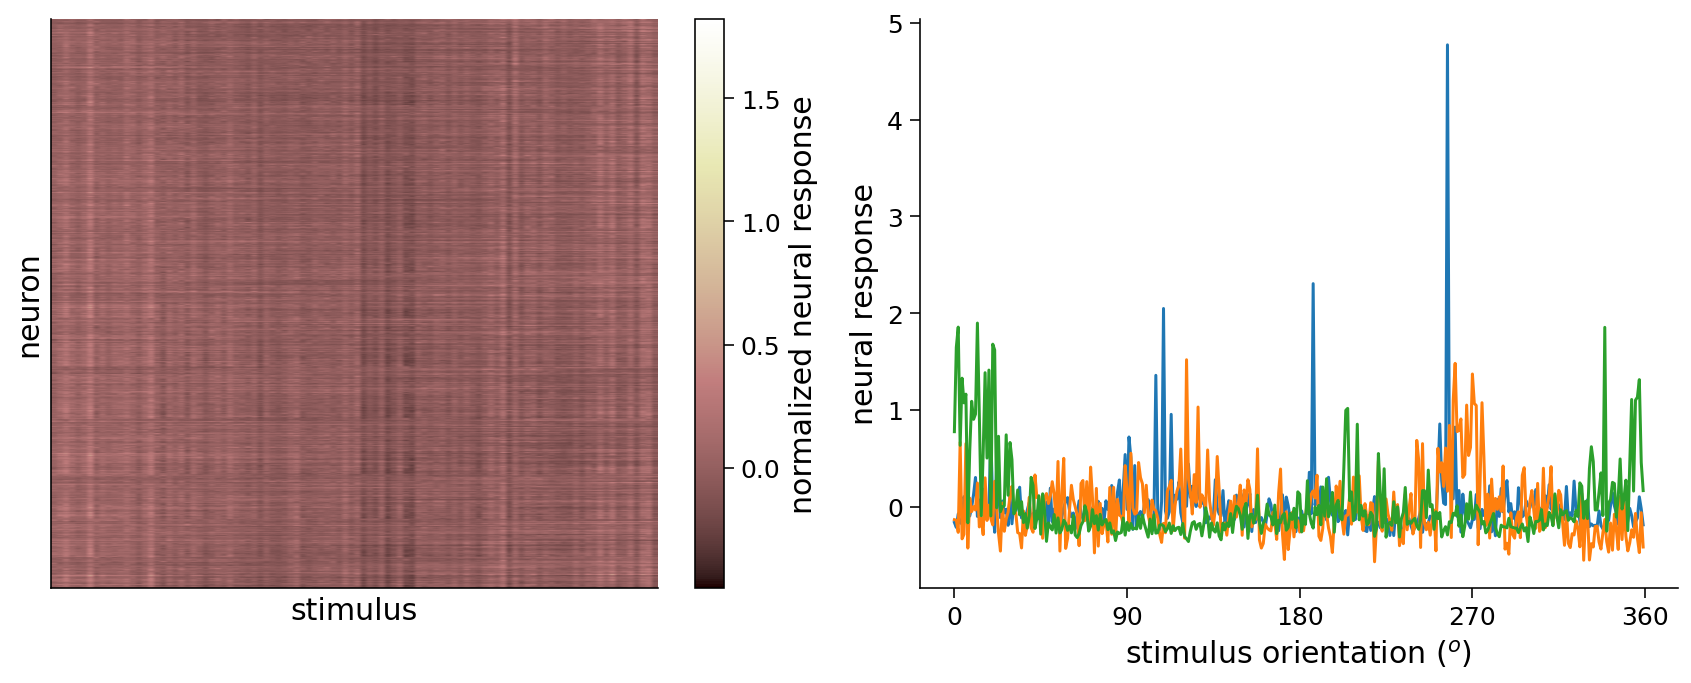

In [ ]:
#@title

#@markdown Execute this cell to load and visualize data

# Load data
resp_all, stimuli_all = load_data()  # argument to this function specifies bin width
n_stimuli, n_neurons = resp_all.shape

print(f'{n_neurons} neurons in response to {n_stimuli} stimuli')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6, 5))

# Visualize data matrix
plot_data_matrix(resp_all[:100, :].T, ax1)  # plot responses of first 100 neurons
ax1.set_xlabel('stimulus')
ax1.set_ylabel('neuron')

# Plot tuning curves of three random neurons
ineurons = np.random.choice(n_neurons, 3, replace=False)  # pick three random neurons
ax2.plot(stimuli_all, resp_all[:, ineurons])
ax2.set_xlabel('stimulus orientation ($^o$)')
ax2.set_ylabel('neural response')
ax2.set_xticks(np.linspace(0, 360, 5))

plt.tight_layout()

In [ ]:
#@title
#@markdown Execute this cell to split into training and test sets

# Set random seeds for reproducibility
np.random.seed(4)
torch.manual_seed(4)

# Split data into training set and testing set
n_train = int(0.6 * n_stimuli)  # use 60% of all data for training set
ishuffle = torch.randperm(n_stimuli)
itrain = ishuffle[:n_train]  # indices of data samples to include in training set
itest = ishuffle[n_train:]  # indices of data samples to include in testing set
stimuli_test = stimuli_all[itest]
resp_test = resp_all[itest]
stimuli_train = stimuli_all[itrain]
resp_train = resp_all[itrain]

iteration 10/50 | loss: 12219.759
iteration 20/50 | loss: 1672.732
iteration 30/50 | loss: 548.097
iteration 40/50 | loss: 235.619
iteration 50/50 | loss: 144.001


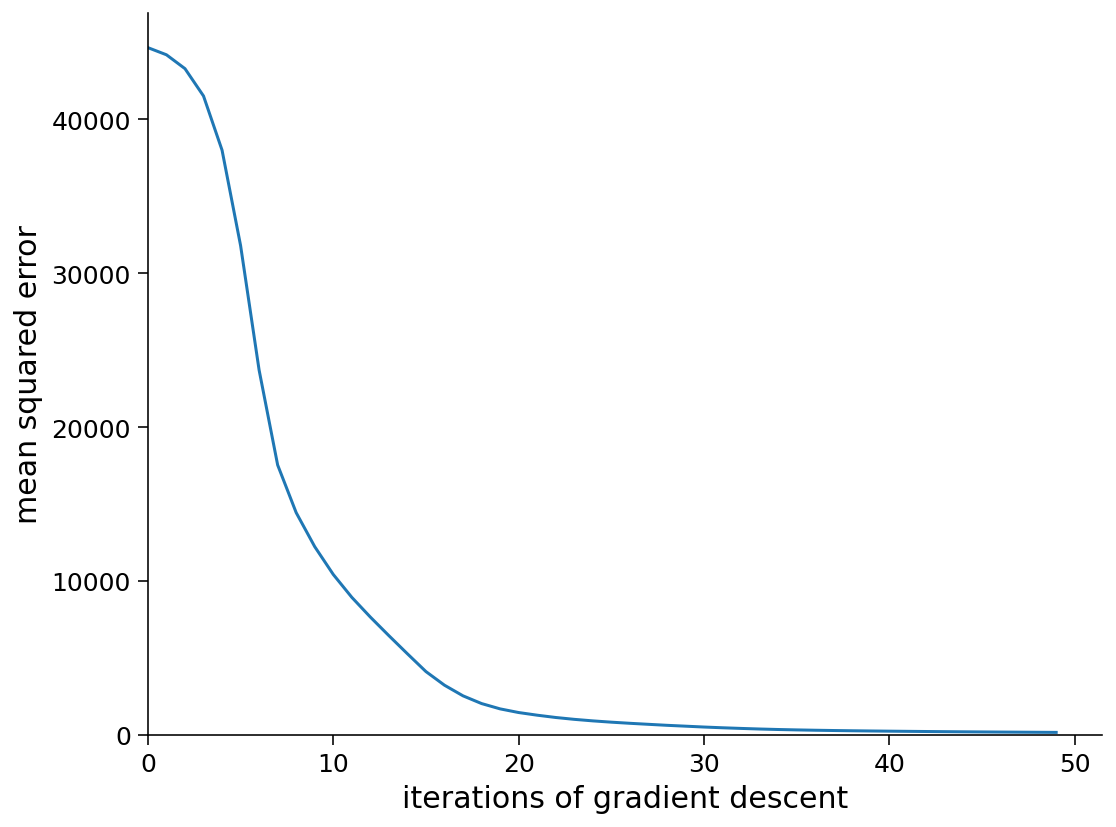

In [ ]:
# @markdown Execute this cell to train the network

class DeepNetReLU(nn.Module):
  """ network with a single hidden layer h with a RELU """

  def __init__(self, n_inputs, n_hidden):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden) # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, 1) # hidden units --> output

  def forward(self, r):

    h = torch.relu(self.in_layer(r)) # h is size (n_inputs, n_hidden)
    y = self.out_layer(h) # y is size (n_inputs, 1)

    return y


def train(net, loss_fn, train_data, train_labels,
          n_epochs=50, learning_rate=1e-4):
  """Run gradient descent to opimize parameters of a given network

  Args:
    net (nn.Module): PyTorch network whose parameters to optimize
    loss_fn: built-in PyTorch loss function to minimize
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data
    n_epochs (int, optional): number of epochs of gradient descent to run
    learning_rate (float, optional): learning rate to use for gradient descent

  Returns:
    (list): training loss over iterations

  """

  # Initialize PyTorch SGD optimizer
  optimizer = optim.SGD(net.parameters(), lr=learning_rate)

  # Placeholder to save the loss at each iteration
  train_loss = []

  # Loop over epochs
  for i in range(n_epochs):

    # compute network output from inputs in train_data
    out = net(train_data)  # compute network output from inputs in train_data

    # evaluate loss function
    loss = loss_fn(out, train_labels)

    # Clear previous gradients
    optimizer.zero_grad()

    # Compute gradients
    loss.backward()

    # Update weights
    optimizer.step()

    # Store current value of loss
    train_loss.append(loss.item())  # .item() needed to transform the tensor output of loss_fn to a scalar


    # Track progress
    if (i + 1) % (n_epochs // 5) == 0:
      print(f'iteration {i + 1}/{n_epochs} | loss: {loss.item():.3f}')

  return train_loss


# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize network with 10 hidden units
net = DeepNetReLU(n_neurons, 10)

# Initialize built-in PyTorch MSE loss function
loss_fn = nn.MSELoss()

# Run gradient descent on data
train_loss = train(net, loss_fn, resp_train, stimuli_train)

# Plot the training loss over iterations of GD
plt.plot(train_loss)
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel('iterations of gradient descent')
plt.ylabel('mean squared error')
plt.show()

## Section 1.1: Peering inside the decoding model


shape of W_in:
(10, 23589)
shape of W_out:
(1, 10)


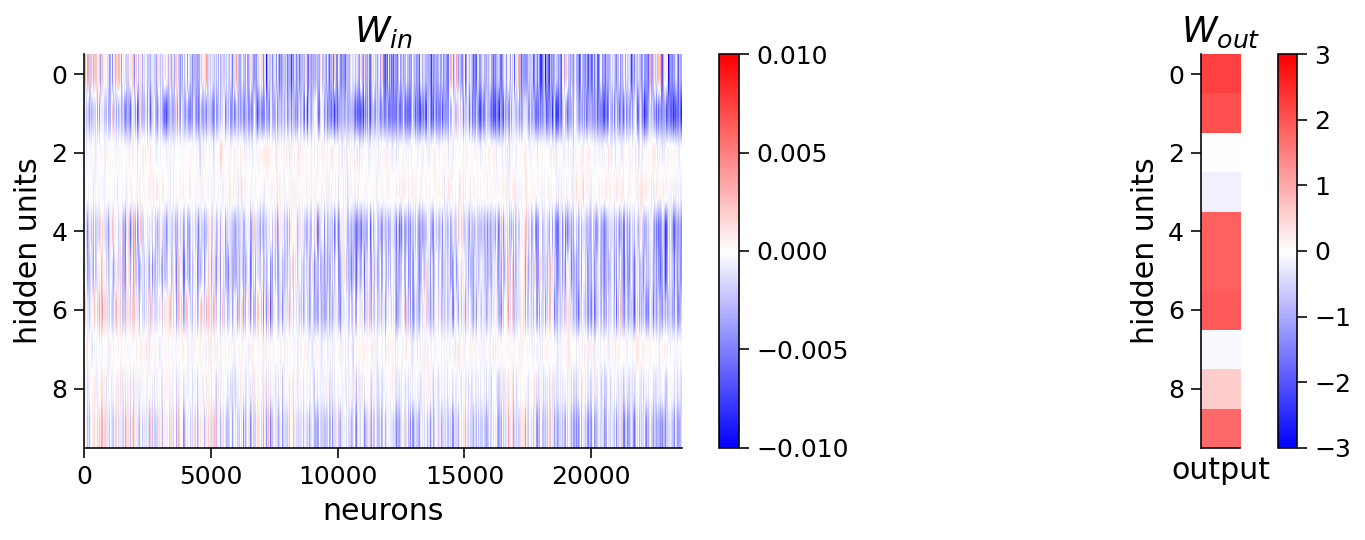

In [ ]:
W_in = net.in_layer.weight.detach().numpy() # we can run .detach() and .numpy() to get a numpy array
print('shape of W_in:')
print(W_in.shape)

W_out = net.out_layer.weight.detach().numpy() # we can run .detach() and .numpy() to get a numpy array
print('shape of W_out:')
print(W_out.shape)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(W_in, aspect='auto', cmap='bwr', vmin=-1e-2, vmax=1e-2)
plt.xlabel('neurons')
plt.ylabel('hidden units')
plt.colorbar()
plt.title('$W_{in}$')

plt.subplot(1,2,2)
plt.imshow(W_out.T, cmap='bwr', vmin=-3, vmax=3)
plt.xticks([])
plt.xlabel('output')
plt.ylabel('hidden units')
plt.colorbar()
plt.title('$W_{out}$')

plt.show()

### Coding Exercise 1.1: Visualizing weights

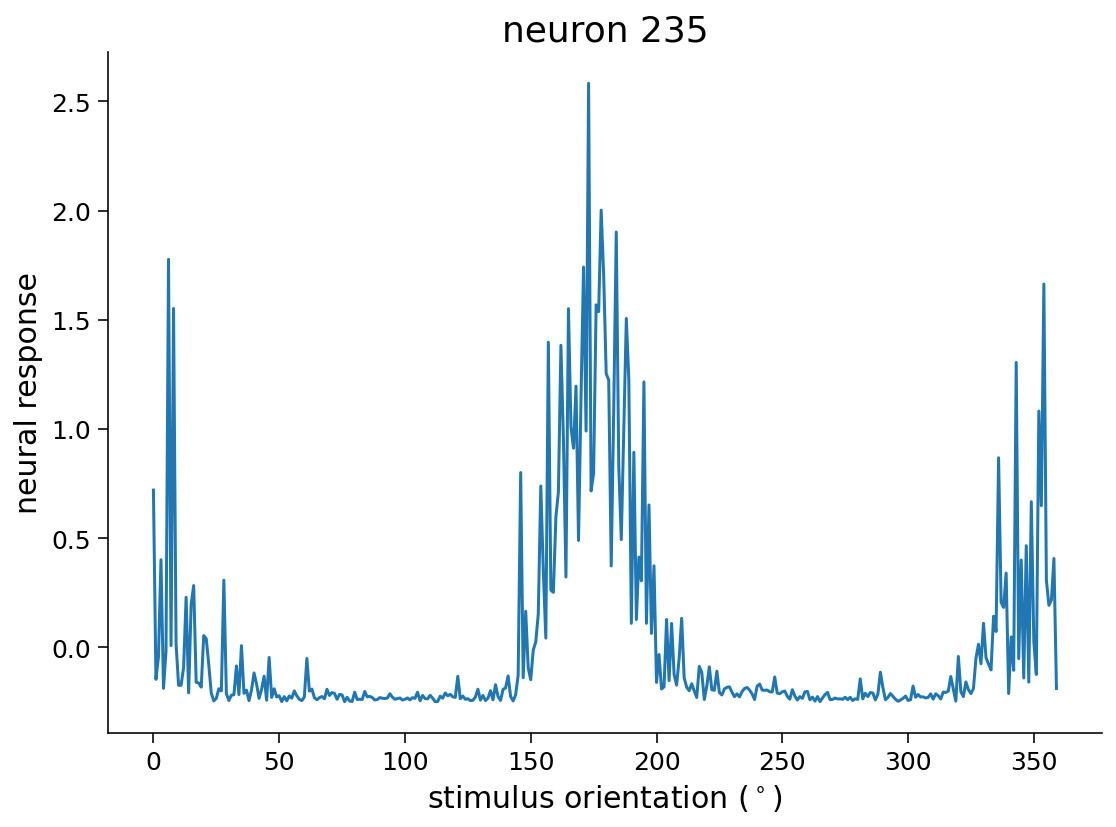

In [ ]:
idx = 235
plt.plot(resp_all[:,idx])
plt.ylabel('neural response')
plt.xlabel('stimulus orientation ($^\circ$)')
plt.title(f'neuron {idx}')
plt.show()

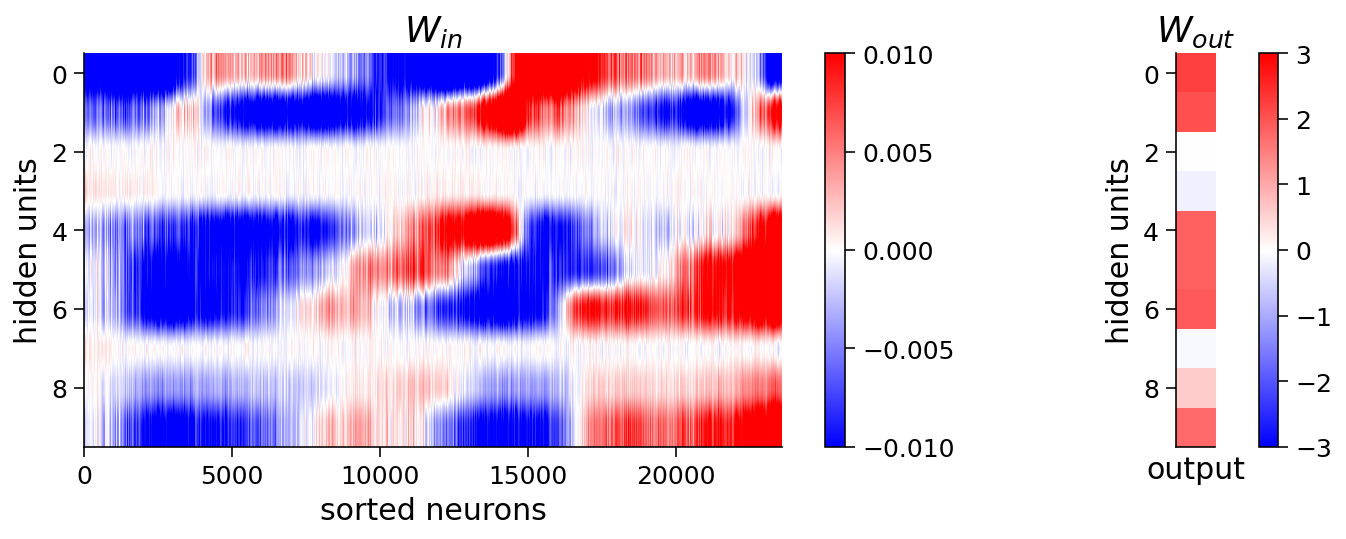

In [ ]:
from scipy.ndimage import gaussian_filter1d

# first let's smooth the tuning curves resp_all to make sure we get
# an accurate peak that isn't just noise
# resp_all is size (n_stimuli, n_neurons)
resp_smoothed = gaussian_filter1d(resp_all, 5, axis=0)
# resp_smoothed is size (n_stimuli, n_neurons)

## find position of max response for each neuron
## aka preferred orientation for each neuron
preferred_orientation = np.argmax(resp_smoothed,axis=0)

## Resort W_in matrix by preferred orientation
isort = preferred_orientation.argsort()
W_in_sorted = W_in[:,isort]

# plot resorted W_in matrix
visualize_weights(W_in_sorted, W_out)

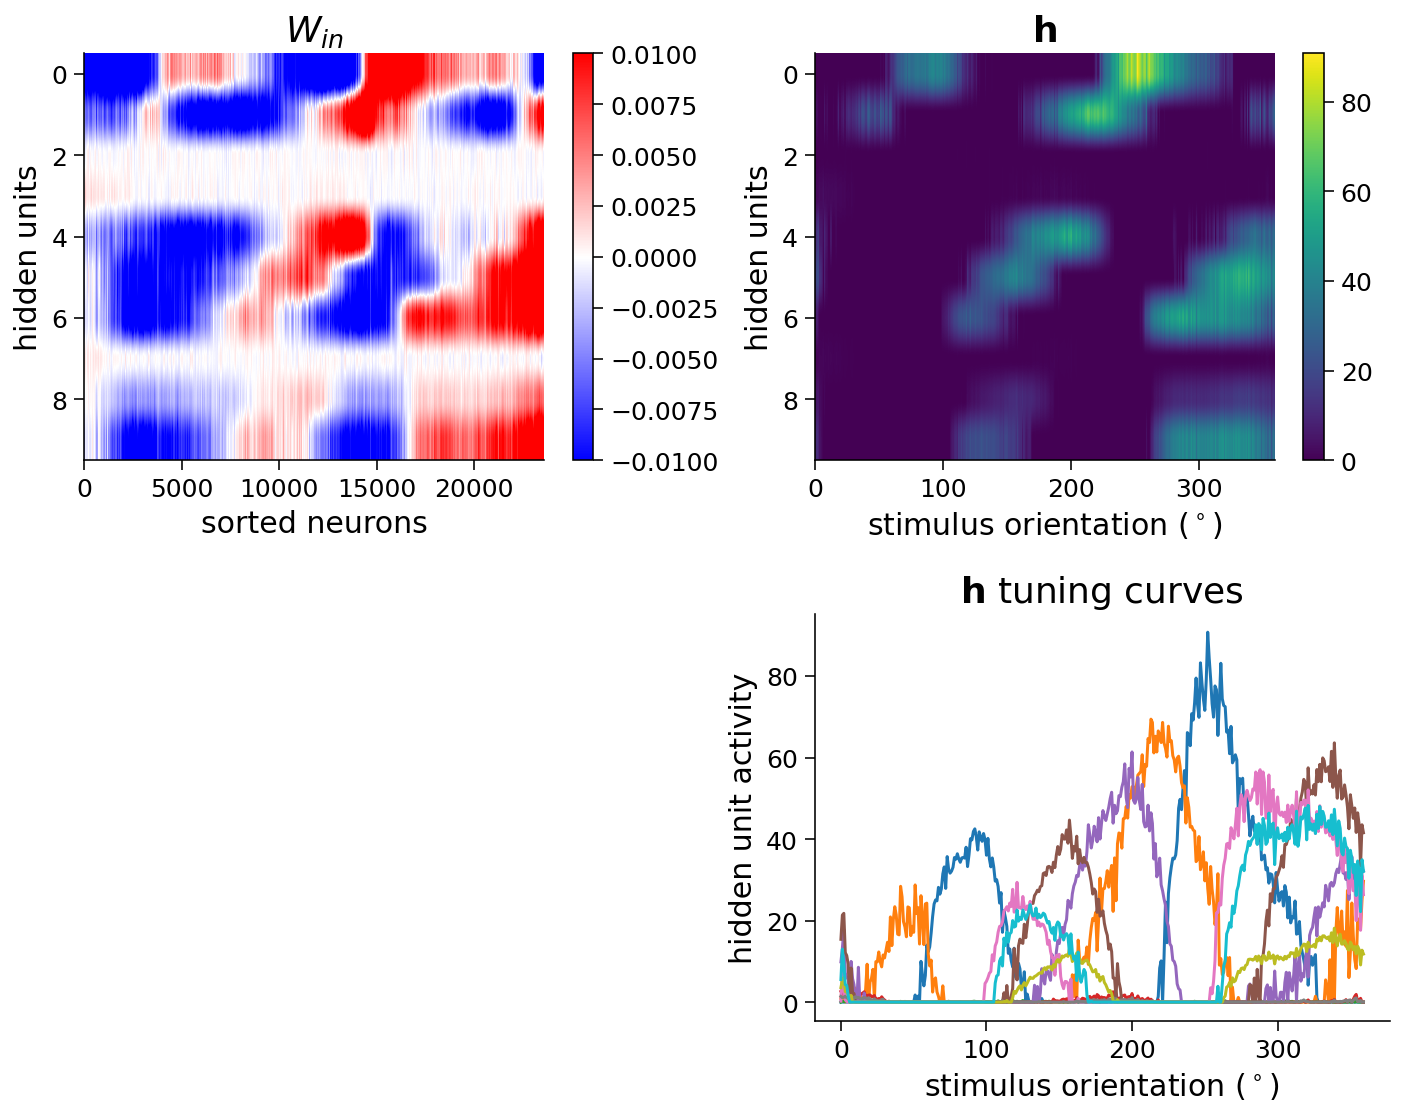

In [ ]:
W_in = net.in_layer.weight.detach() # size (10, n_neurons)
b_in = net.in_layer.bias.detach().unsqueeze(1) # size (10, 1)

# Compute hidden unit activity h
h = torch.relu(W_in @ resp_all.T + b_in)
h = h.detach().numpy() # we can run .detach() and .numpy() to get a numpy array

# Visualize
visualize_hidden_units(W_in_sorted, h)

## Section 1.2: Generalization performance with test data

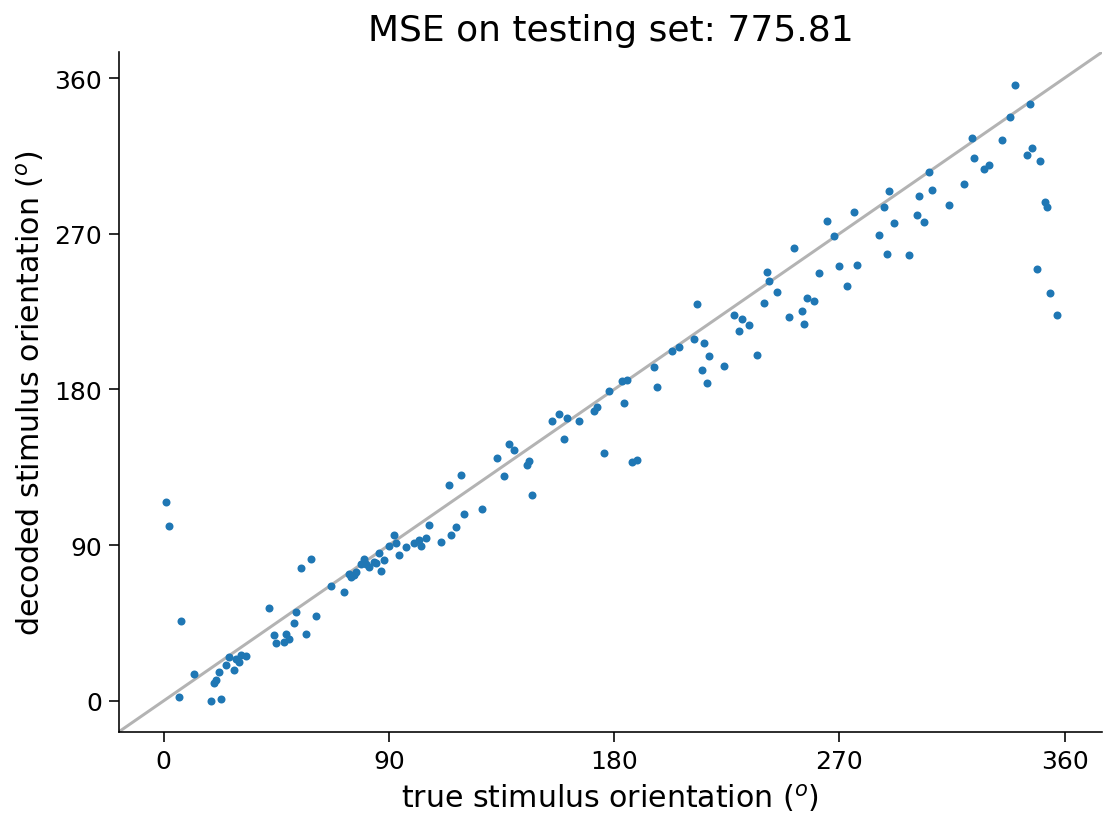

In [ ]:
#@title
#@markdown Execute this cell to evaluate and plot test error

out = net(resp_test)  # decode stimulus orientation for neural responses in testing set
ori = stimuli_test  # true stimulus orientations
test_loss = loss_fn(out, ori)  # MSE on testing set (Hint: use loss_fn initialized in previous exercise)

plt.plot(ori, out.detach(), '.')  # N.B. need to use .detach() to pass network output into plt.plot()
identityLine()  # draw the identity line y=x; deviations from this indicate bad decoding!
plt.title('MSE on testing set: %.2f' % test_loss.item())  # N.B. need to use .item() to turn test_loss into a scalar
plt.xlabel('true stimulus orientation ($^o$)')
plt.ylabel('decoded stimulus orientation ($^o$)')
axticks = np.linspace(0, 360, 5)
plt.xticks(axticks)
plt.yticks(axticks)
plt.show()

# Section 2: Decoding - Evaluating & improving models

---
## Section 2.1: Model criticism

Let's now take a step back and think about how our model is succeeding/failing and how to improve it.

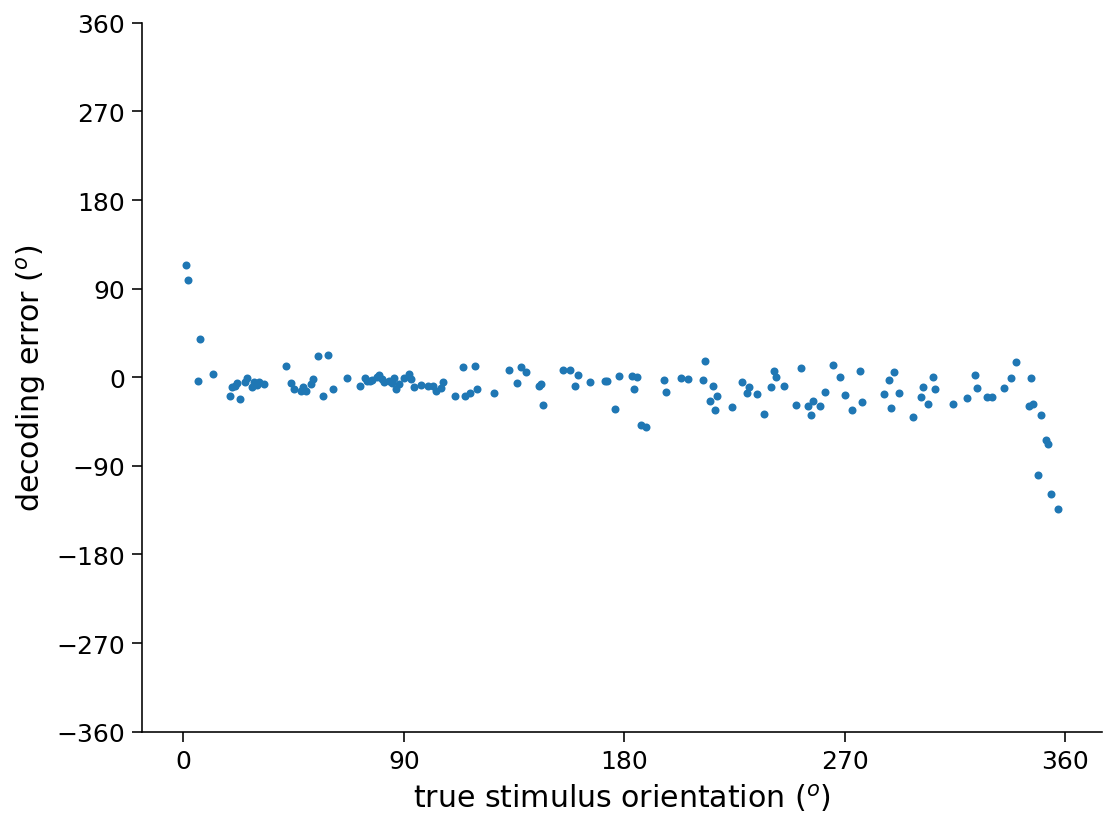

In [ ]:
#@title
#@markdown Execute this cell to plot decoding error

out = net(resp_test)  # decode stimulus orientation for neural responses in testing set
ori = stimuli_test  # true stimulus orientations
error = out - ori  # decoding error


plt.plot(ori, error.detach(), '.')   # plot decoding error as a function of true orientation (make sure all arguments to plt.plot() have been detached from PyTorch network!)

# Plotting
plt.xlabel('true stimulus orientation ($^o$)')
plt.ylabel('decoding error ($^o$)')
plt.xticks(np.linspace(0, 360, 5))
plt.yticks(np.linspace(-360, 360, 9))
plt.show()

## Section 2.2: Improving the loss function 

In [ ]:
# Deep network for classification
class DeepNetSoftmax(nn.Module):
  """Deep Network with one hidden layer, for classification

  Args:
    n_inputs (int): number of input units
    n_hidden (int): number of units in hidden layer
    n_classes (int): number of outputs, i.e. number of classes to output
      probabilities for

  Attributes:
    in_layer (nn.Linear): weights and biases of input layer
    out_layer (nn.Linear): weights and biases of output layer

  """

  def __init__(self, n_inputs, n_hidden, n_classes):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden)  # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, n_classes)  # hidden units --> outputs
    self.logprob = nn.LogSoftmax(dim=1)  # probabilities across columns should sum to 1 (each output row corresponds to a different input)

  def forward(self, r):
    """Predict stimulus orientation bin from neural responses

    Args:
      r (torch.Tensor): n_stimuli x n_inputs tensor with neural responses to n_stimuli

    Returns:
      torch.Tensor: n_stimuli x n_classes tensor with predicted class probabilities

    """
    h = torch.relu(self.in_layer(r))
    logp = self.logprob(self.out_layer(h))
    return logp

### Coding Exercise 2.2: A new loss function
In the next cell, we've provided most of the code to train and test a network to decode stimulus orientations via classification, by minimizing the negative log likelihood. Fill in the missing pieces.

Once you've done this, have a look at the plotted results. Does changing the loss function from mean squared error to a classification loss solve our problems? Note that errors may still occur -- but are these errors as bad as the ones that our network above was making?

In [ ]:
#@markdown Run this cell to create train function that uses test_data and L1 and L2 terms for next exercise
def train(net, loss_fn, train_data, train_labels,
          n_iter=50, learning_rate=1e-4,
          test_data=None, test_labels=None,
          L2_penalty=0, L1_penalty=0):
  """Run gradient descent to opimize parameters of a given network

  Args:
    net (nn.Module): PyTorch network whose parameters to optimize
    loss_fn: built-in PyTorch loss function to minimize
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data
    n_iter (int, optional): number of iterations of gradient descent to run
    learning_rate (float, optional): learning rate to use for gradient descent
    test_data (torch.Tensor, optional): n_test x n_neurons tensor with neural
      responses to test on
    test_labels (torch.Tensor, optional): n_test x 1 tensor with orientations of
      the stimuli corresponding to each row of test_data
    L2_penalty (float, optional): l2 penalty regularizer coefficient
    L1_penalty (float, optional): l1 penalty regularizer coefficient

  Returns:
    (list): training loss over iterations

  """

  # Initialize PyTorch SGD optimizer
  optimizer = optim.SGD(net.parameters(), lr=learning_rate)

  # Placeholder to save the loss at each iteration
  train_loss = []
  test_loss = []

  # Loop over epochs
  for i in range(n_iter):

    # compute network output from inputs in train_data
    out = net(train_data)  # compute network output from inputs in train_data

    # evaluate loss function
    if L2_penalty==0 and L1_penalty==0:
      # normal loss function
      loss = loss_fn(out, train_labels)
    else:
      # custom loss function from bonus exercise 3.3
      loss = loss_fn(out, train_labels, net.in_layer.weight,
                     L2_penalty, L1_penalty)

    # Clear previous gradients
    optimizer.zero_grad()
    # Compute gradients
    loss.backward()

    # Update weights
    optimizer.step()

    # Store current value of loss
    train_loss.append(loss.item())  # .item() needed to transform the tensor output of loss_fn to a scalar

    # Get loss for test_data, if given (we will use this in the bonus exercise 3.2 and 3.3)
    if test_data is not None:
      out_test = net(test_data)
      # evaluate loss function
      if L2_penalty==0 and L1_penalty==0:
        # normal loss function
        loss_test = loss_fn(out_test, test_labels)
      else:
        # (BONUS code) custom loss function from Bonus exercise 3.3
        loss_test = loss_fn(out_test, test_labels, net.in_layer.weight,
                            L2_penalty, L1_penalty)
      test_loss.append(loss_test.item())  # .item() needed to transform the tensor output of loss_fn to a scalar

    # Track progress
    if (i + 1) % (n_iter // 5) == 0:
      if test_data is None:
        print(f'iteration {i + 1}/{n_iter} | loss: {loss.item():.3f}')
      else:
        print(f'iteration {i + 1}/{n_iter} | loss: {loss.item():.3f} | test_loss: {loss_test.item():.3f}')

  if test_data is None:
    return train_loss
  else:
    return train_loss, test_loss

iteration 200/1000 | loss: 0.004 | test_loss: 0.252
iteration 400/1000 | loss: 0.002 | test_loss: 0.255
iteration 600/1000 | loss: 0.001 | test_loss: 0.259
iteration 800/1000 | loss: 0.001 | test_loss: 0.263
iteration 1000/1000 | loss: 0.001 | test_loss: 0.265
>>> fraction correct = 0.861


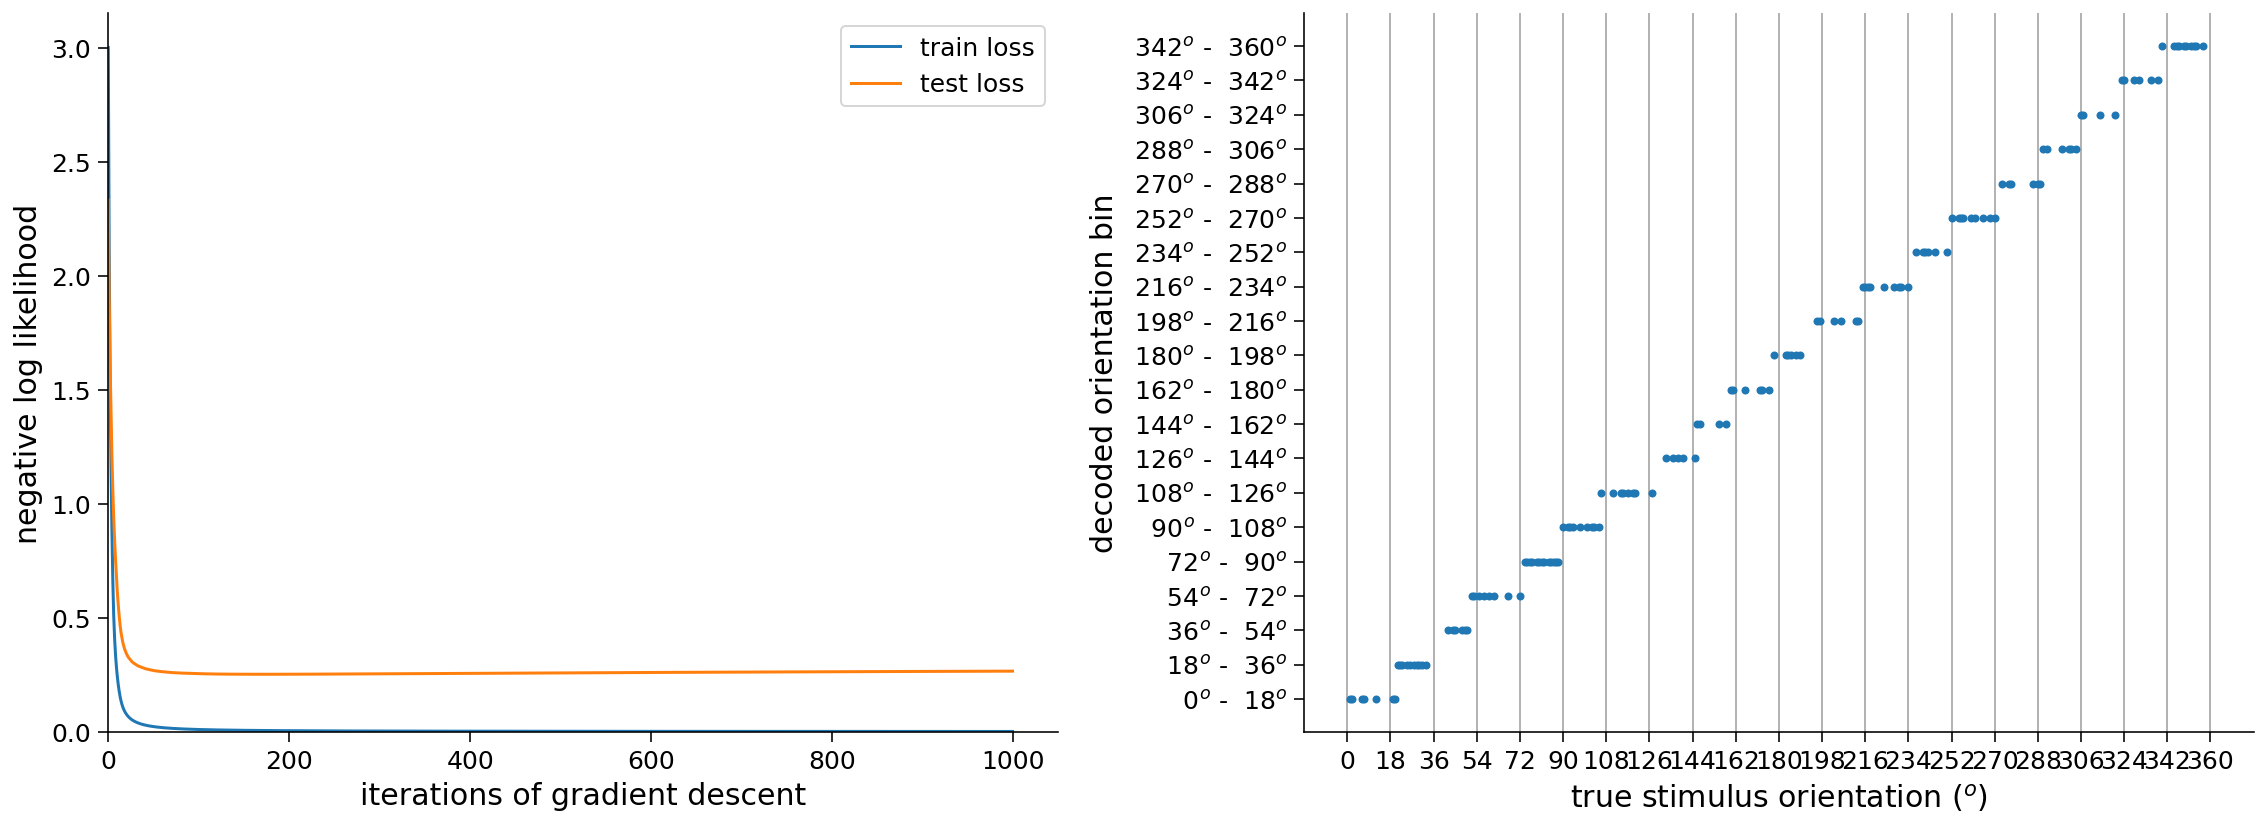

In [ ]:
def decode_orientation(net, n_classes, loss_fn,
                       train_data, train_labels, test_data, test_labels,
                       n_iter=1000, L2_penalty=0, L1_penalty=0):
  """ Initialize, train, and test deep network to decode binned orientation from neural responses

  Args:
    net (nn.Module): deep network to run
    n_classes (scalar): number of classes in which to bin orientation
    loss_fn (function): loss function to run
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians
    test_data (torch.Tensor): n_test x n_neurons tensor with neural
      responses to train on
    test_labels (torch.Tensor): n_test x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians
    n_iter (int, optional): number of iterations to run optimization
    L2_penalty (float, optional): l2 penalty regularizer coefficient
    L1_penalty (float, optional): l1 penalty regularizer coefficient

  Returns:
    (list, torch.Tensor): training loss over iterations, n_test x 1 tensor with predicted orientations of the
      stimuli from decoding neural network
  """

  # Bin stimulus orientations in training set
  train_binned_labels = stimulus_class(train_labels, n_classes)
  test_binned_labels = stimulus_class(test_labels, n_classes)


  # Run GD on training set data, using learning rate of 0.1
  # (add optional arguments test_data and test_binned_labels!)
  train_loss, test_loss = train(net, loss_fn, train_data, train_binned_labels,
                                learning_rate=0.1, test_data=test_data,
                                test_labels=test_binned_labels, n_iter=n_iter,
                                L2_penalty=L2_penalty, L1_penalty=L1_penalty)

  # Decode neural responses in testing set data
  out = net(test_data)
  out_labels = np.argmax(out.detach(), axis=1)  # predicted classes

  frac_correct = (out_labels==test_binned_labels).sum() / len(test_binned_labels)
  print(f'>>> fraction correct = {frac_correct:.3f}')

  return train_loss, test_loss, out_labels


# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

n_classes = 20

# Initialize network
net = DeepNetSoftmax(n_neurons, 20, n_classes)# use M=20 hidden units

# Initialize built-in PyTorch negative log likelihood loss function
loss_fn = nn.CrossEntropyLoss()

# Train network and run it on test images
# this function uses the train function you wrote before
train_loss, test_loss, predicted_test_labels = decode_orientation(net, n_classes, loss_fn,
                                                                  resp_train, stimuli_train, resp_test, stimuli_test)

# Plot results
plot_decoded_results(train_loss, test_loss, stimuli_test, predicted_test_labels)

shape of W_in:
(20, 23589)


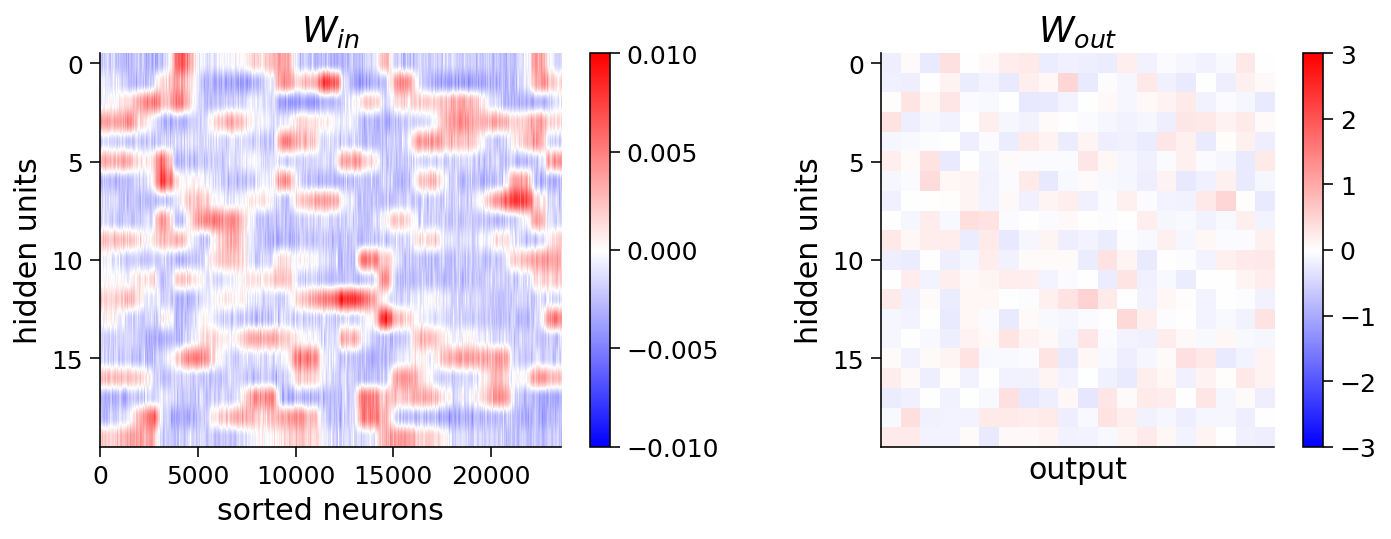

In [ ]:
W_in = net.in_layer.weight.detach().numpy() # we can run detach and numpy to get a numpy array
print('shape of W_in:')
print(W_in.shape)

W_out = net.out_layer.weight.detach().numpy()

# plot resorted W_in matrix
visualize_weights(W_in[:,isort], W_out)

## Section 2.3: Regularization

### Coding Exercise 2.3: Add regularization to training 

We will create a new loss function that adds L1 and L2 regularization. 
In particular, you will:
* add L2 loss penalty to the weights 
* add L1 loss penalty to the weights


We will then train the network using this loss function. Full training will take a few minutes: if you want to train for just a few steps to speed up the code while iterating on your code, you can decrease the n_iter input from 500. 

Hint: since we are using `torch` instead of `np`, we will use `torch.abs` instead of `np.absolute`. You can use `torch.sum` or `.sum()` to sum over a tensor.


iteration 200/1000 | loss: 0.226 | test_loss: 0.477
iteration 400/1000 | loss: 0.167 | test_loss: 0.411
iteration 600/1000 | loss: 0.142 | test_loss: 0.387
iteration 800/1000 | loss: 0.126 | test_loss: 0.371
iteration 1000/1000 | loss: 0.116 | test_loss: 0.360
>>> fraction correct = 0.889


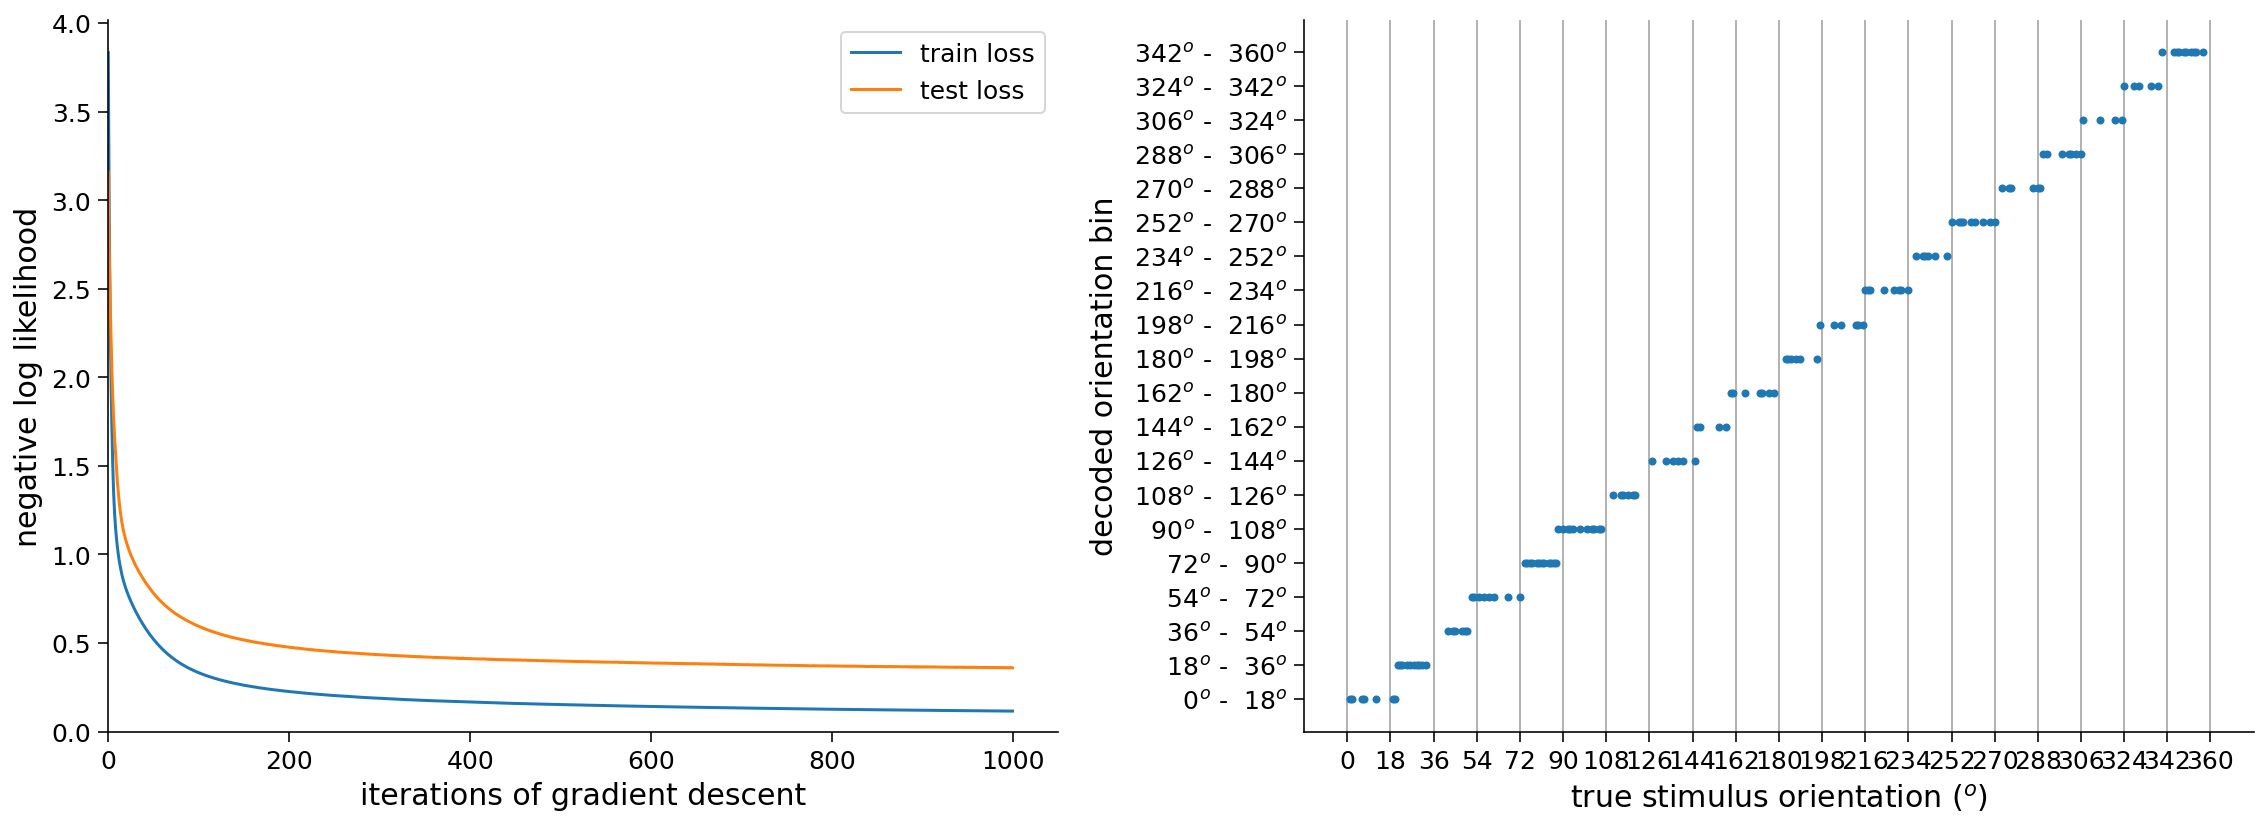

In [ ]:
def regularized_loss(output, target, weights, L2_penalty=0, L1_penalty=0):
  """loss function with L2 and L1 regularization

  Args:
    output (torch.Tensor): output of network
    target (torch.Tensor): neural response network is trying to predict
    weights (torch.Tensor): linear layer weights from neurons to hidden units (net.in_layer.weight)
    L2_penalty : scaling factor of sum of squared weights
    L1_penalty : scaling factor for sum of absolute weights

  Returns:
    (torch.Tensor) mean-squared error with L1 and L2 penalties added

  """

  loss_fn = nn.NLLLoss()
  loss = loss_fn(output, target)

  L2 = L2_penalty * torch.sum(weights**2)
  L1 = L1_penalty * torch.sum(torch.abs(weights))
  loss += L1 + L2

  return loss


# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

n_classes = 20

# Initialize network
net = DeepNetSoftmax(n_neurons, 20, n_classes)  # use M=20 hidden units

# Here you can play with L2_penalty > 0, L1_penalty > 0
train_loss, test_loss, predicted_test_labels = decode_orientation(net, n_classes,
                                                                  regularized_loss,
                                                                  resp_train, stimuli_train,
                                                                  resp_test, stimuli_test,
                                                                  n_iter=1000,
                                                                  L2_penalty=1e-2,
                                                                  L1_penalty=5e-4)

# Plot results
plot_decoded_results(train_loss, test_loss, stimuli_test, predicted_test_labels)

shape of W_in:
(20, 23589)


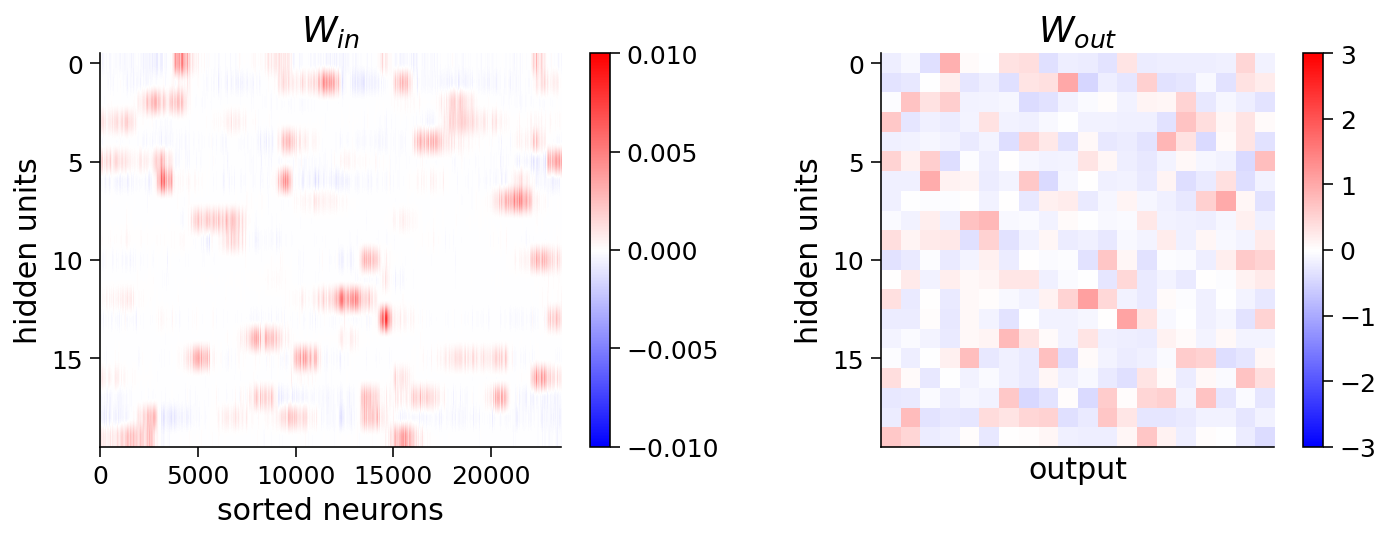

In [ ]:
W_in = net.in_layer.weight.detach().numpy() # we can run detach and numpy to get a numpy array
print('shape of W_in:')
print(W_in.shape)

W_out = net.out_layer.weight.detach().numpy()

visualize_weights(W_in[:,isort], W_out)

---
# Section 3: Encoding - Convolutional Networks for Encoding

In [ ]:
# @markdown Execute this cell to load data
import hashlib
import requests

fname = "W3D4_stringer_oribinned6_split.npz"
url = "https://osf.io/p3aeb/download"
expected_md5 = "b3f7245c6221234a676b71a1f43c3bb5"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

def load_data_split(data_name=fname):
  """Load mouse V1 data from Stringer et al. (2019)

  Data from study reported in this preprint:
  https://www.biorxiv.org/content/10.1101/679324v2.abstract

  These data comprise time-averaged responses of ~20,000 neurons
  to ~4,000 stimulus gratings of different orientations, recorded
  through Calcium imaginge. The responses have been normalized by
  spontaneous levels of activity and then z-scored over stimuli, so
  expect negative numbers. The repsonses were split into train and
  test and then each set were averaged in bins of 6 degrees.

  This function returns the relevant data (neural responses and
  stimulus orientations) in a torch.Tensor of data type torch.float32
  in order to match the default data type for nn.Parameters in
  Google Colab.

  It will hold out some of the trials when averaging to allow us to have test
  tuning curves.

  Args:
    data_name (str): filename to load

  Returns:
    resp_train (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins.
    resp_test (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins
    stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
        of each stimulus, in degrees. This is actually the mean orientation
        of all stimuli in each bin.

  """
  with np.load(data_name) as dobj:
    data = dict(**dobj)
  resp_train = data['resp_train']
  resp_test = data['resp_test']
  stimuli = data['stimuli']

  # Return as torch.Tensor
  resp_train_tensor = torch.tensor(resp_train, dtype=torch.float32)
  resp_test_tensor = torch.tensor(resp_test, dtype=torch.float32)
  stimuli_tensor = torch.tensor(stimuli, dtype=torch.float32)

  return resp_train_tensor, resp_test_tensor, stimuli_tensor

## Section 3.1: Neural tuning curves

In the next cell, we plot the turning curves of a random subset of neurons. We have binned the stimuli orientations more than in Tutorial 1. We create the gratings images as above for the 60 orientations below, and save them to a variable `grating_stimuli`.

Rerun the cell to look at different example neurons and observe the diversity of tuning curves in the population. How can we fit these neural responses with an encoding model?

resp_train contains averaged responses of 23589 neurons to 60 binned stimuli
grating_stimuli contains 60 stimuli of size 12 x 16


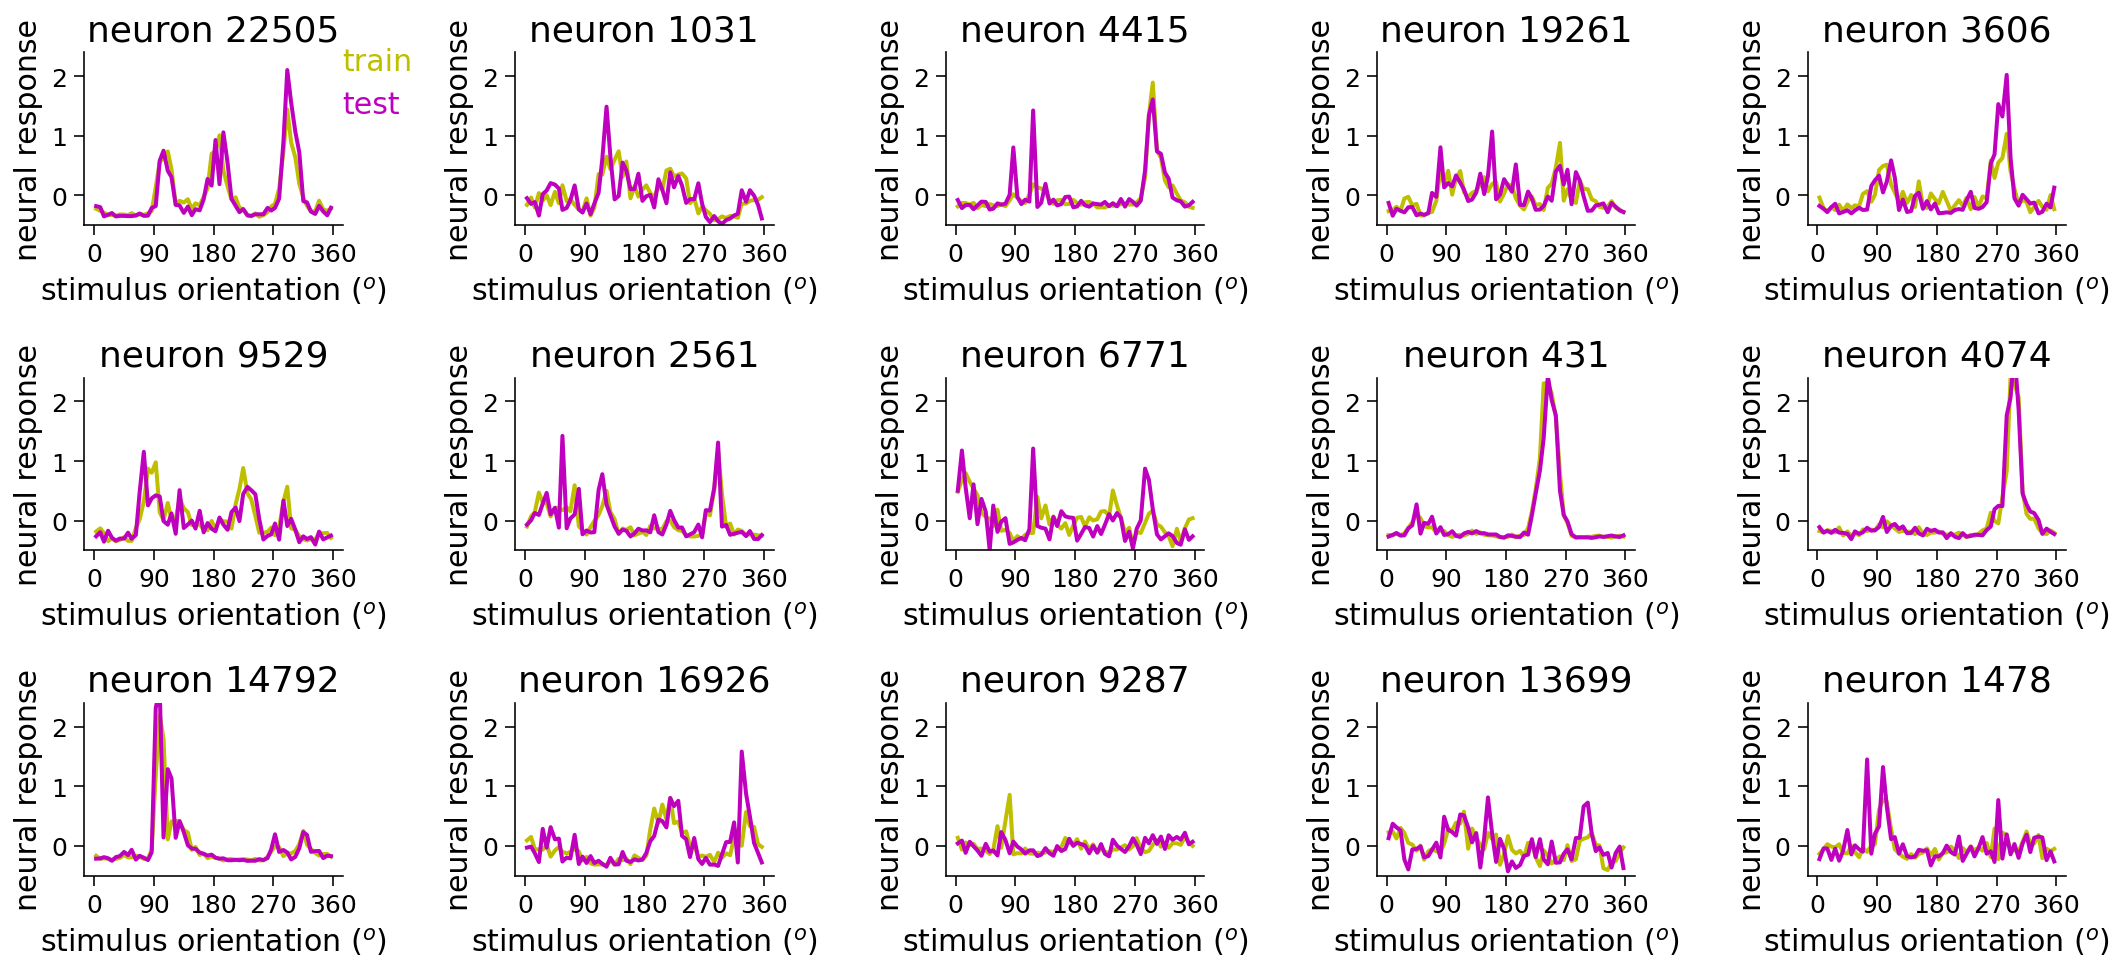

In [ ]:
# @markdown Execute this cell to load data, create stimuli, and plot neural tuning curves

### Load data and bin at 8 degrees
# responses are split into test and train
resp_train, resp_test, stimuli = load_data_split()
n_stimuli, n_neurons = resp_train.shape
print('resp_train contains averaged responses of %i neurons to %i binned stimuli' % (n_neurons, n_stimuli))
#print(resp_train.shape)

# also make stimuli into images
orientations = np.linspace(0, 360, 61)[:-1] - 180
grating_stimuli = np.zeros((60, 1, 12, 16), np.float32)
for i, ori in enumerate(orientations):
  grating_stimuli[i,0] = grating(ori, res=0.025)#[18:30, 24:40]

grating_stimuli = torch.from_numpy(grating_stimuli)
print('grating_stimuli contains 60 stimuli of size 12 x 16')

# Visualize tuning curves
fig, axs = plt.subplots(3, 5, figsize=(15,7))
for k, ax in enumerate(axs.flatten()):
  neuron_index = np.random.choice(n_neurons)  # pick random neuron
  plot_tuning(ax, stimuli, resp_train[:, neuron_index], resp_test[:, neuron_index], neuron_index, linewidth=2)
  if k==0:
    ax.text(1.0, 0.9, 'train', color='y', transform=ax.transAxes)
    ax.text(1.0, 0.65, 'test', color='m', transform=ax.transAxes)
fig.tight_layout()
plt.show()

## Section 3.2: Adding a fully-connected layer to create encoding model

### Coding Exercise 3.2: Add linear layer


In [ ]:
# @markdown Execute to get `train` function for our neural encoding model

def train(net, custom_loss, train_data, train_labels,
          test_data=None, test_labels=None,
          learning_rate=10, n_iter=500, L2_penalty=0., L1_penalty=0.):
  """Run gradient descent for network without batches

  Args:
    net (nn.Module): deep network whose parameters to optimize with SGD
    custom_loss: loss function for network
    train_data: training data (n_train x input features)
    train_labels: training labels (n_train x output features)
    test_data: test data (n_train x input features)
    test_labels: test labels (n_train x output features)
    learning_rate (float): learning rate for gradient descent
    n_epochs (int): number of epochs to run gradient descent
    L2_penalty (float): magnitude of L2 penalty
    L1_penalty (float): magnitude of L1 penalty

  Returns:
    train_loss: training loss across iterations
    test_loss: testing loss across iterations

  """
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9) # Initialize PyTorch SGD optimizer
  train_loss = np.nan * np.zeros(n_iter)  # Placeholder for train loss
  test_loss = np.nan * np.zeros(n_iter)  # Placeholder for test loss

  # Loop over epochs
  for i in range(n_iter):
    if n_iter < 10:
      for param_group in self.optimizer.param_groups:
        param_group['lr'] = np.linspace(0, learning_rate, 10)[n_iter]
    y_pred = net(train_data) # Forward pass: compute predicted y by passing train_data to the model.

    if L2_penalty>0 or L1_penalty>0:
      weights = net.out_layer.weight
      loss = custom_loss(y_pred, train_labels, weights, L2_penalty, L1_penalty)
    else:
      loss = custom_loss(y_pred, train_labels)

    ### Update parameters
    optimizer.zero_grad() # zero out gradients
    loss.backward() # Backward pass: compute gradient of the loss with respect to model parameters
    optimizer.step() # step parameters in gradient direction
    train_loss[i] = loss.item()  # .item() transforms the tensor to a scalar and does .detach() for us

    # Track progress
    if (i+1) % (n_iter // 10) == 0 or i==0:
      if test_data is not None and test_labels is not None:
        y_pred = net(test_data)
        if L2_penalty>0 or L1_penalty>0:
          loss = custom_loss(y_pred, test_labels, weights, L2_penalty, L1_penalty)
        else:
          loss = custom_loss(y_pred, test_labels)
        test_loss[i] = loss.item()
        print(f'iteration {i+1}/{n_iter} | train loss: {train_loss[i]:.4f} | test loss: {test_loss[i]:.4f}')
      else:
        print(f'iteration {i+1}/{n_iter} | train loss: {train_loss[i]:.4f}')

  return train_loss, test_loss

iteration 1/200 | train loss: 1.8908 | test loss: 1.8840
iteration 20/200 | train loss: 1.0872 | test loss: 1.0775
iteration 40/200 | train loss: 0.4673 | test loss: 0.4844
iteration 60/200 | train loss: 0.2017 | test loss: 0.2343
iteration 80/200 | train loss: 0.1073 | test loss: 0.1458
iteration 100/200 | train loss: 0.0768 | test loss: 0.1168
iteration 120/200 | train loss: 0.0686 | test loss: 0.1090
iteration 140/200 | train loss: 0.0662 | test loss: 0.1068
iteration 160/200 | train loss: 0.0650 | test loss: 0.1059
iteration 180/200 | train loss: 0.0644 | test loss: 0.1054
iteration 200/200 | train loss: 0.0639 | test loss: 0.1050


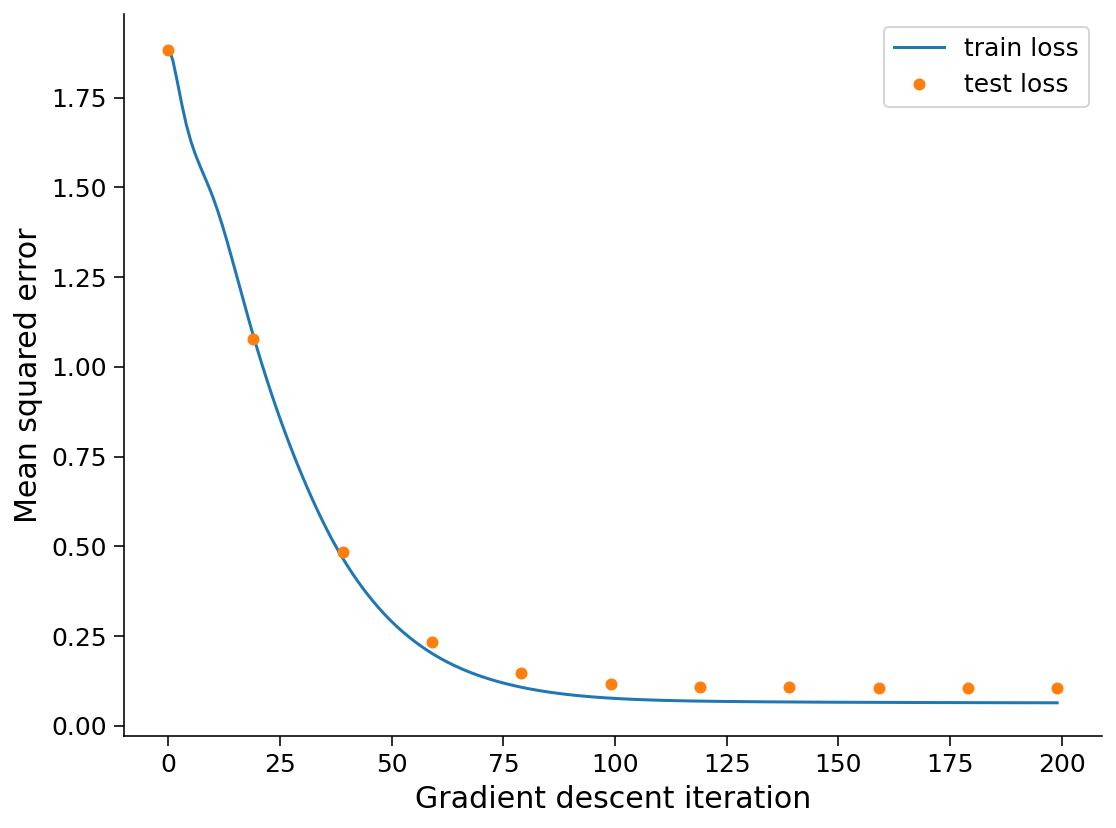

In [ ]:
class ConvFC(nn.Module):
  """Deep network with one convolutional layer + one fully connected layer

  Attributes:
    conv (nn.Conv1d): convolutional layer
    dims (tuple): shape of convolutional layer output
    out_layer (nn.Linear): linear layer

  """

  def __init__(self, n_neurons, c_in=1, c_out=6, K=7, b=12*16,
               filters=None):
    """ initialize layer
    Args:
        c_in: number of input stimulus channels
        c_out: number of convolutional channels
        K: size of each convolutional filter
        h: number of stimulus bins, n_bins
    """
    super().__init__()
    self.conv = nn.Conv2d(c_in, c_out, kernel_size=K,
                          padding=K//2, stride=1)
    self.dims = (c_out, b)  # dimensions of conv layer output
    M = np.prod(self.dims) # number of hidden units
    self.out_layer = nn.Linear(M, n_neurons)

    # initialize weights
    if filters is not None:
      self.conv.weight = nn.Parameter(filters)
      self.conv.bias = nn.Parameter(torch.zeros((c_out,), dtype=torch.float32))

    nn.init.normal_(self.out_layer.weight, std=0.01) # initialize weights to be small

  def forward(self, s):
    """ Predict neural responses to stimuli s

    Args:
        s (torch.Tensor): n_stimuli x c_in x h x w tensor with stimuli

    Returns:
        y (torch.Tensor): n_stimuli x n_neurons tensor with predicted neural responses

    """
    a = self.conv(s)  # output of convolutional layer
    a = a.view(-1, np.prod(self.dims))  # flatten each convolutional layer output into a vector
    y = self.out_layer(a)

    return y


device = torch.device('cpu')

# (Optional) To speed up processing, go to "Runtime" menu and "Change runtime"
# and select GPU processing, then uncomment line below, otherwise runtime will
# be ~ 2 minutes
# device = torch.device('cuda')

# Initialize network
n_neurons = resp_train.shape[1]
## Initialize with filters from Tutorial 2
example_filters = filters(out_channels=6, K=7)

net = ConvFC(n_neurons, filters = example_filters)
net = net.to(device)

# Run GD on training set data
# ** this time we are also providing the test data to estimate the test loss
train_loss, test_loss = train(net, regularized_MSE_loss,
                              train_data=grating_stimuli.to(device), train_labels=resp_train.to(device),
                              test_data=grating_stimuli.to(device), test_labels=resp_test.to(device),
                              n_iter=200, learning_rate=2,
                              L2_penalty=5e-4, L1_penalty=1e-6)

# Visualize
plot_training_curves(train_loss, test_loss)

How well can we fit single neuron tuning curves with this model? What aspects of the tuning curves are we capturing?

In [ ]:
# @markdown Execute this cell to examine predictions for random subsets of neurons

y_pred = net(grating_stimuli.to(device))
# Visualize tuning curves & plot neural predictions
fig, axs = plt.subplots(2, 5, figsize=(15,6))
for k, ax in enumerate(axs.flatten()):
  ineur = np.random.choice(n_neurons)
  plot_prediction(ax, y_pred[:,ineur].detach().cpu(),
                  resp_train[:,ineur],
                  resp_test[:,ineur])
  if k==0:
    ax.text(.1, 1., 'train', color='y', transform=ax.transAxes)
    ax.text(.1, 0.9, 'test', color='m', transform=ax.transAxes)
    ax.text(.1, 0.8, 'prediction', color='g', transform=ax.transAxes)

fig.tight_layout()
plt.show()

We can see if the convolutional channels changed at all from their initialization as center-surround and Gabor filters. If they don't then it means that they were a sufficient basis set to explain the responses of the neurons to orientations to the accuracy seen above.

In [ ]:
# get weights of conv layer in convLayer
out_channels = 6 # how many convolutional channels to have in our layer
weights = net.conv.weight.detach().cpu()
print(weights.shape) # Can you identify what each of the dimensions are?

plot_weights(weights, channels = np.arange(0, out_channels))